In [1]:
# Import core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# Load the dataset 
data = pd.read_csv("customer_support_tickets.csv")

# Display the first 5 rows
data.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [3]:
# Overview of dataset
print("Dataset Shape:", data.shape)
print("\nDataset Info:")
print(data.info())

# Basic statistics
print("\nStatistical Summary:")
print(data.describe(include='all'))


Dataset Shape: (8469, 17)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority      

In [4]:
# Handle missing values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['Customer Satisfaction Rating'], inplace=True)

# Convert dates
data['Date of Purchase'] = pd.to_datetime(data['Date of Purchase'], errors='coerce')

# Drop unnecessary columns
drop_cols = ['Customer Name', 'Customer Email', 'Ticket ID', 'Ticket Description', 'Resolution']
data.drop(columns=drop_cols, inplace=True)

# Encode categorical columns
label_encoders = {}
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

print("Data Preprocessing Completed")


Data Preprocessing Completed


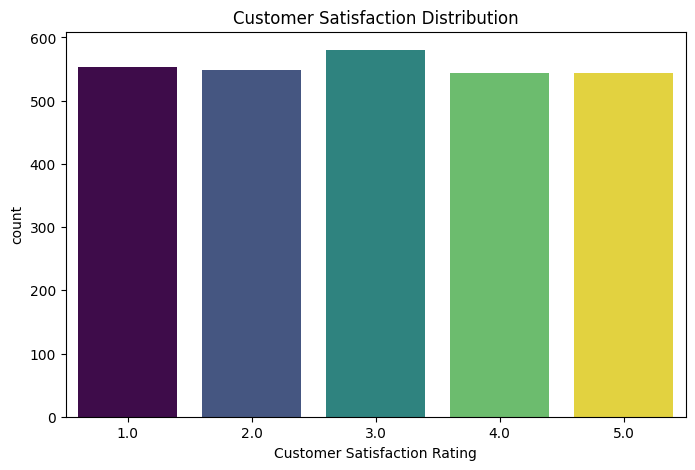

In [5]:
# Distribution of Satisfaction Ratings
plt.figure(figsize=(8,5))
sns.countplot(x='Customer Satisfaction Rating', data=data, hue= 'Customer Satisfaction Rating',palette='viridis', legend = False)
plt.title("Customer Satisfaction Distribution")
plt.show()

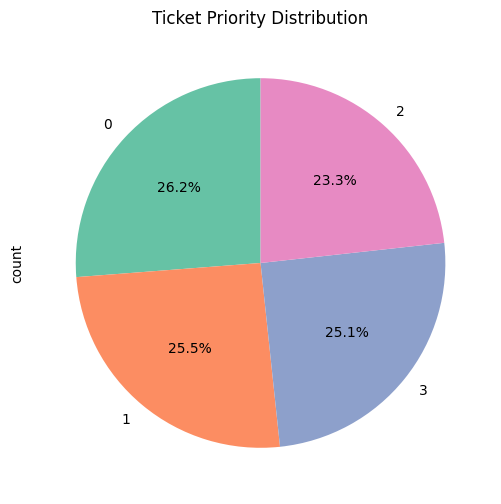

In [6]:
# Ticket Priority
plt.figure(figsize=(6,6))
data['Ticket Priority'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
plt.title("Ticket Priority Distribution")
plt.show()

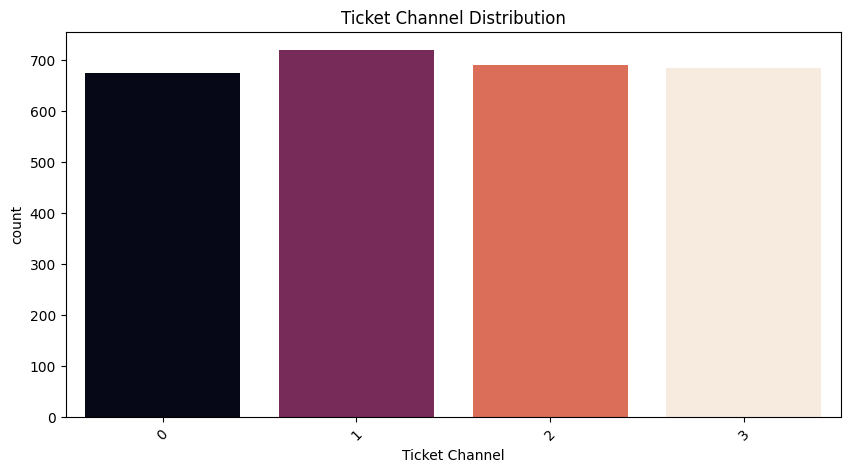

In [7]:
#  Ticket Channel
plt.figure(figsize=(10,5))
sns.countplot(x='Ticket Channel', data=data,hue='Ticket Channel', palette='rocket',legend=False)
plt.title("Ticket Channel Distribution")
plt.xticks(rotation=45)
plt.show()

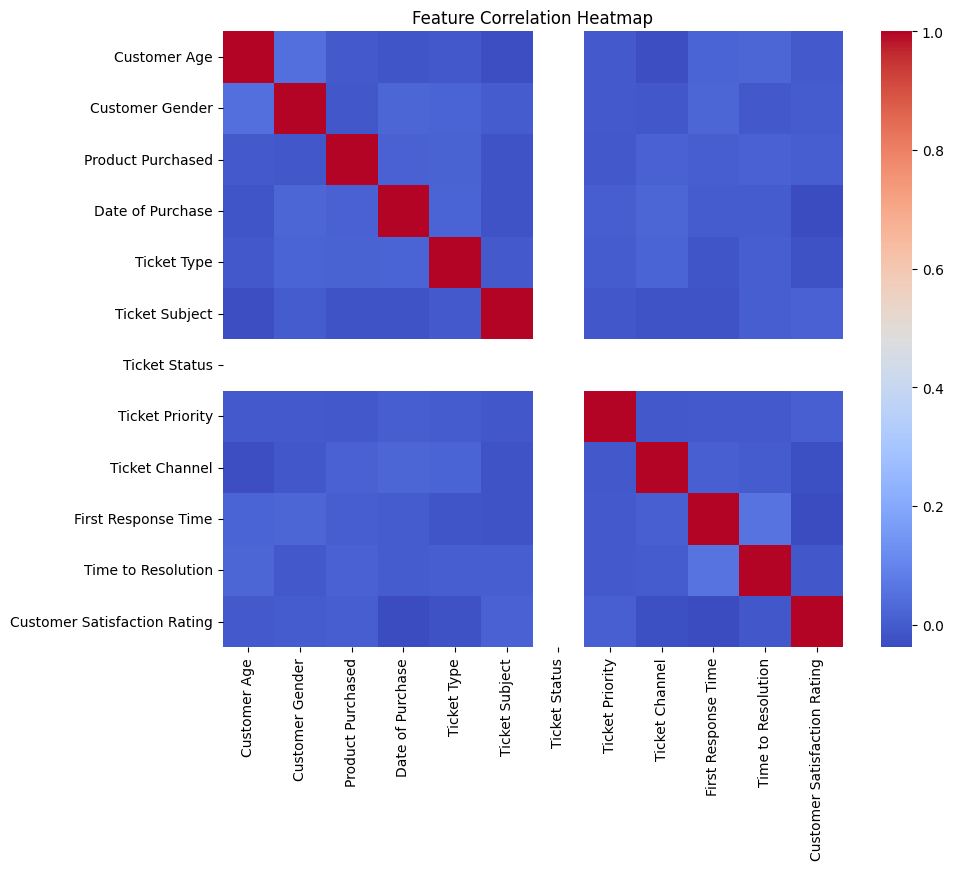

In [8]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


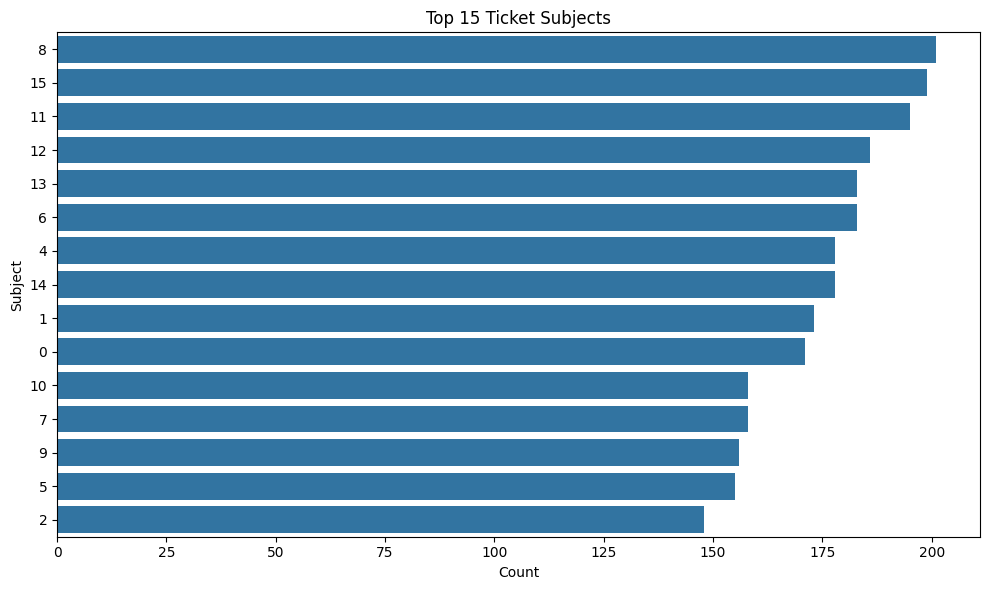

No valid keywords found.
 Skipping bigram plot: empty vocabulary; perhaps the documents only contain stop words


In [9]:
# Text Insights: Top subjects and keywords 
from collections import Counter
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Make sure Ticket Subject is string
subjects = data['Ticket Subject'].fillna('').astype(str)

# Top exact subjects
top_subjects = subjects.value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_subjects.values, y=top_subjects.index)
plt.title('Top 15 Ticket Subjects')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.tight_layout()
plt.show()

# Simple tokenizer
def tokenize(txt):
    tokens = re.findall(r"[A-Za-z0-9']+", txt.lower())
    stop = set("a an the and or for to of in on at by from with without into over under between within is are was were be been being have has had do does did can could should would may might not no yes you your we our they their he she it its this that these those i me my about as if than then too very more most less least just also only so such".split())
    return [t for t in tokens if t not in stop and len(t) > 2]

all_tokens = []
for s in subjects:
    all_tokens.extend(tokenize(s))

if all_tokens:
    tokens_df = pd.DataFrame(Counter(all_tokens).most_common(20), columns=['token', 'count'])
    plt.figure(figsize=(10,6))
    sns.barplot(x='count', y='token', data=tokens_df)
    plt.title('Top 20 Keywords in Ticket Subjects')
    plt.xlabel('Count')
    plt.ylabel('Keyword')
    plt.tight_layout()
    plt.show()
else:
    print("No valid keywords found.")

# Safe bigram frequency
try:
    cv = CountVectorizer(ngram_range=(2,2), min_df=1)
    X_bi = cv.fit_transform(subjects)
    bi_sums = X_bi.sum(axis=0).A1
    bigrams = pd.Series(bi_sums, index=cv.get_feature_names_out()).sort_values(ascending=False).head(20)

    plt.figure(figsize=(10,6))
    sns.barplot(x=bigrams.values, y=bigrams.index)
    plt.title('Top 20 Bigrams in Ticket Subjects')
    plt.xlabel('Count')
    plt.ylabel('Bigram')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(" Skipping bigram plot:", e)


In [10]:
# feature engineering model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Clean preprocessing again to remove problematic types 

# Drop text/date columns that ML cannot handle directly
drop_cols = ['Customer Name', 'Customer Email', 'Ticket ID', 'Ticket Description',
             'Resolution', 'Date of Purchase']
data_clean = data.drop(columns=[c for c in drop_cols if c in data.columns], errors='ignore')

# Convert categorical columns using LabelEncoder
le = LabelEncoder()
for col in data_clean.select_dtypes(include=['object']).columns:
    data_clean[col] = le.fit_transform(data_clean[col].astype(str))

# Replace inf / NaN
data_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
data_clean.dropna(subset=['Customer Satisfaction Rating'], inplace=True)
data_clean.fillna(0, inplace=True)

# Define features and target
X = data_clean.drop(columns=['Customer Satisfaction Rating'])
y = data_clean['Customer Satisfaction Rating']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale only numeric columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_test = scaler.transform(X_test.select_dtypes(include=[np.number]))

print("Feature Engineering Completed — clean numeric data only")


Feature Engineering Completed — clean numeric data only


In [11]:
# random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rfc = RandomForestClassifier(random_state=42, n_estimators=200)
rfc.fit(X_train, y_train)
y_pred_rf = rfc.predict(X_test)

print("Random Forest Model Performance")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Model Performance
Accuracy: 0.201

Classification Report:
               precision    recall  f1-score   support

         1.0       0.21      0.21      0.21       166
         2.0       0.19      0.20      0.20       165
         3.0       0.20      0.21      0.21       174
         4.0       0.16      0.17      0.17       163
         5.0       0.24      0.22      0.23       163

    accuracy                           0.20       831
   macro avg       0.20      0.20      0.20       831
weighted avg       0.20      0.20      0.20       831



In [12]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Model Performance")
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Model Performance
Accuracy: 0.214

Classification Report:
               precision    recall  f1-score   support

         1.0       0.19      0.18      0.19       166
         2.0       0.20      0.21      0.20       165
         3.0       0.23      0.30      0.26       174
         4.0       0.21      0.27      0.24       163
         5.0       0.23      0.11      0.15       163

    accuracy                           0.21       831
   macro avg       0.21      0.21      0.21       831
weighted avg       0.22      0.21      0.21       831



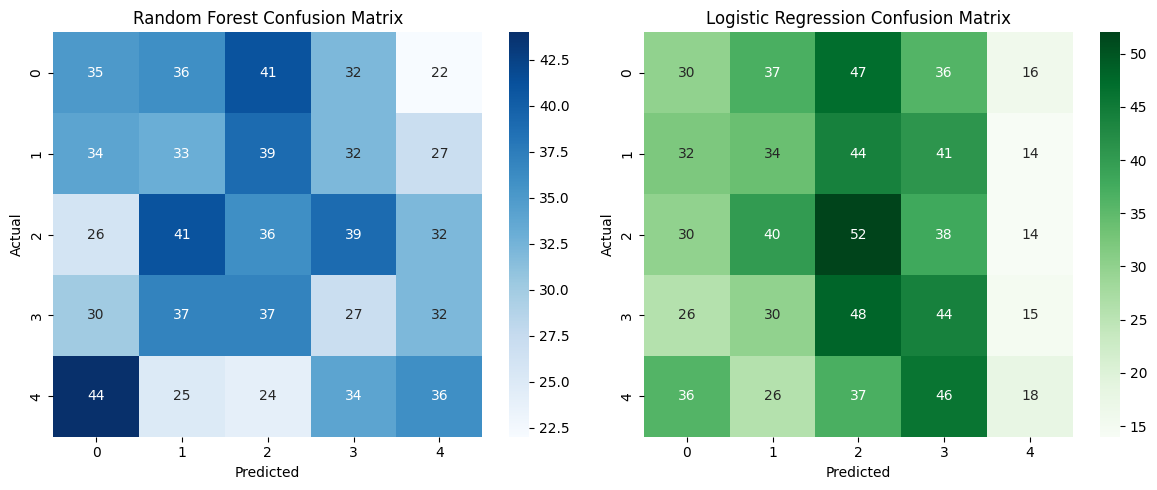

In [13]:
# confusion matrices
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()



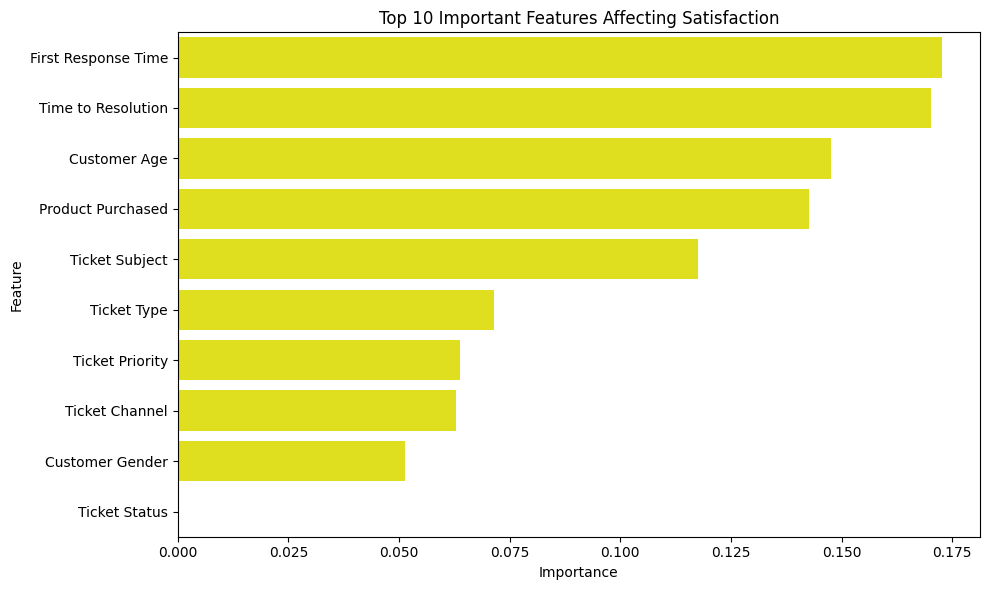

In [14]:
# feature importance

feature_importances = pd.Series(
    rfc.feature_importances_,
    index=data_clean.drop('Customer Satisfaction Rating', axis=1).columns
).sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index,color='yellow')
plt.title('Top 10 Important Features Affecting Satisfaction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [15]:
# save model and data
import joblib

data_clean.to_csv("cleaned_customer_data.csv", index=False)
joblib.dump(rfc, "customer_satisfaction_model.pkl")

print("Cleaned data and trained model saved successfully.")


Cleaned data and trained model saved successfully.


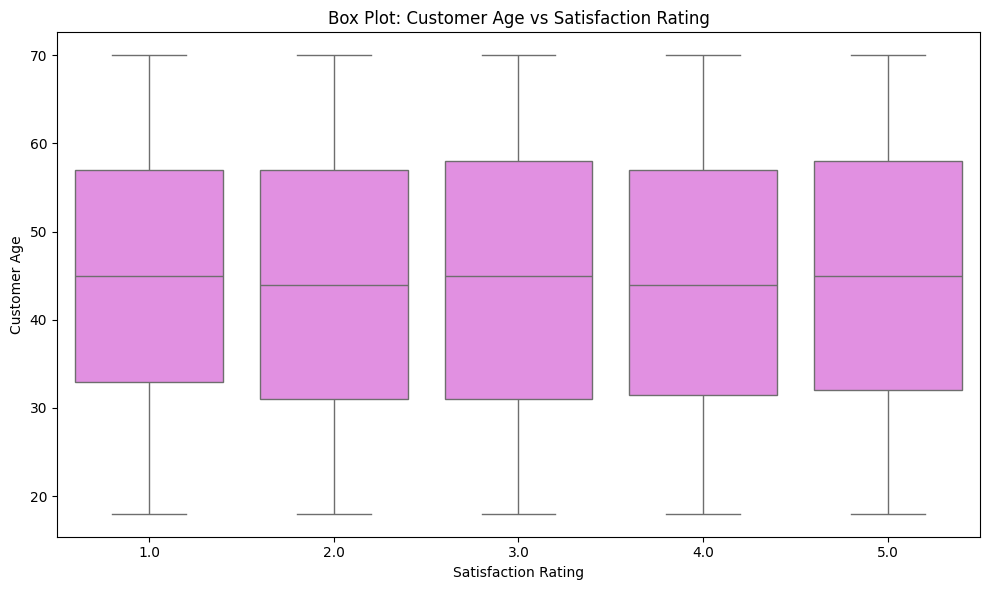

In [19]:
# Box Plot — Distribution of Age vs Satisfaction
plt.figure(figsize=(10,6))
sns.boxplot(x='Customer Satisfaction Rating', y='Customer Age', data=df_viz,color='violet')
plt.title('Box Plot: Customer Age vs Satisfaction Rating')
plt.xlabel('Satisfaction Rating')
plt.ylabel('Customer Age')
plt.tight_layout()
plt.show()

In [17]:
df_viz = data_clean.copy()

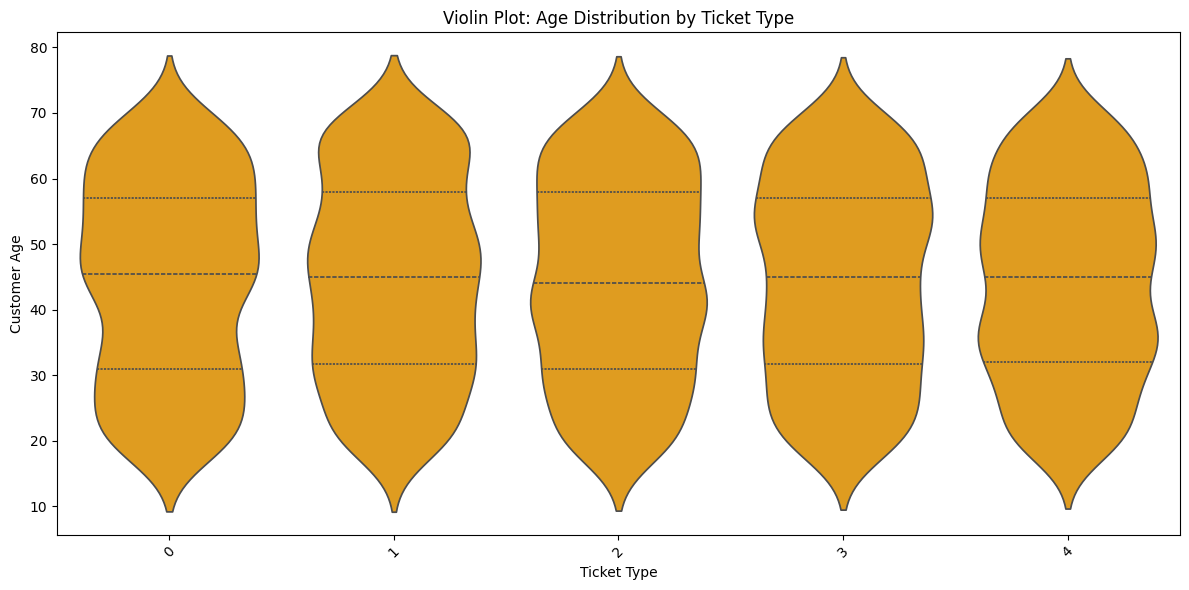

In [22]:
# Violin Plot — Age Distribution per Ticket Type
if 'Ticket Type' in df_viz.columns:
    plt.figure(figsize=(12,6))
    sns.violinplot(x='Ticket Type', y='Customer Age', data=df_viz, inner='quartile',color='orange')
    plt.title('Violin Plot: Age Distribution by Ticket Type')
    plt.xlabel('Ticket Type')
    plt.ylabel('Customer Age')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

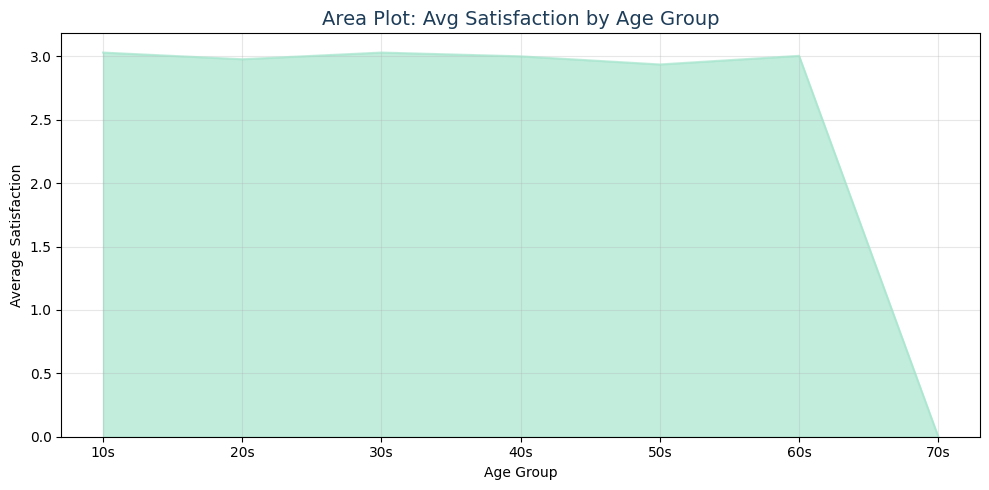

In [26]:
# AREA PLOT — Average Satisfaction by Age Group
if 'Customer Age' in df_viz.columns:
    df_viz['Age Group'] = pd.cut(df_viz['Customer Age'],
                                 bins=[10,20,30,40,50,60,70,80],
                                 labels=['10s','20s','30s','40s','50s','60s','70s'])
    avg_satis = df_viz.groupby('Age Group', observed=False)['Customer Satisfaction Rating'].mean()
    avg_satis.plot(kind='area', color='#A8E6CF', alpha=0.7, figsize=(10,5))
    plt.title('Area Plot: Avg Satisfaction by Age Group', fontsize=14, color='#1E3D59')
    plt.xlabel('Age Group')
    plt.ylabel('Average Satisfaction')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


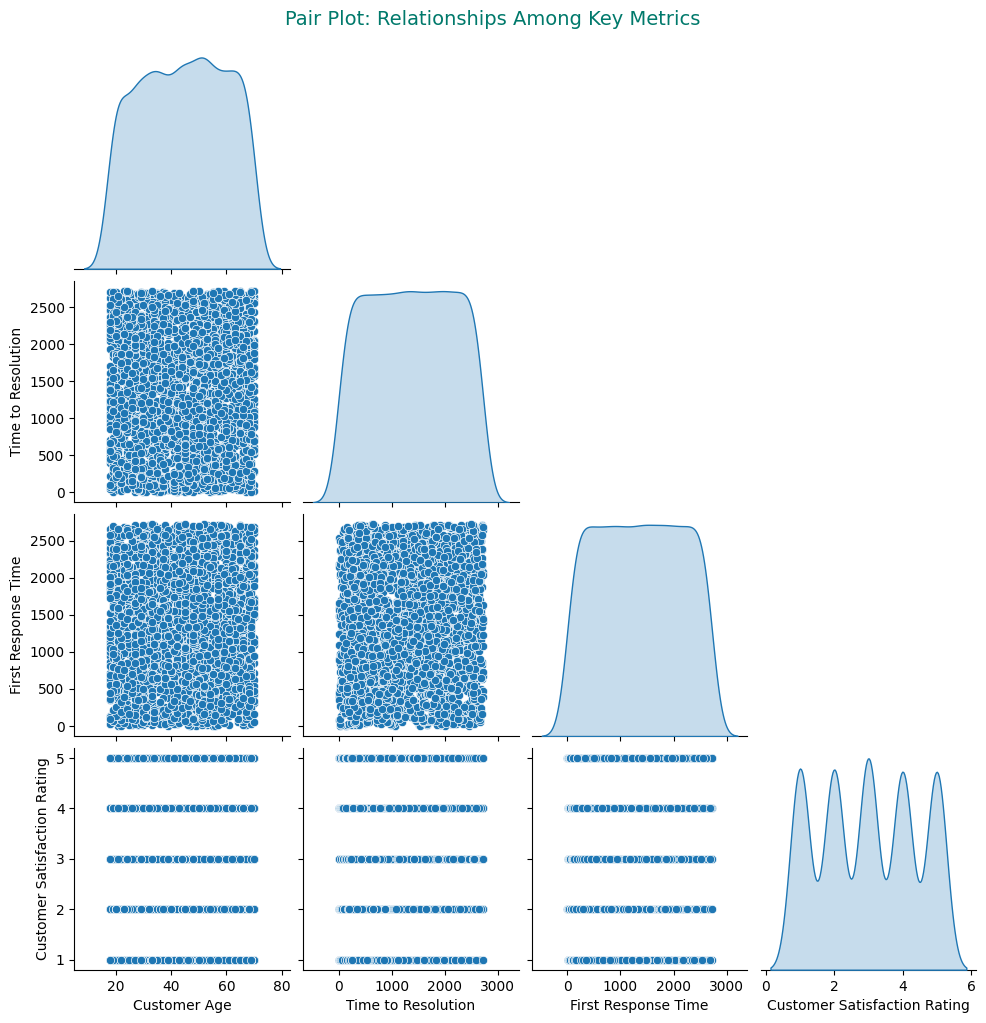

In [28]:
# PAIR PLOT — Relationships among numeric variables (no warning version)
num_cols = ['Customer Age', 'Time to Resolution', 'First Response Time', 'Customer Satisfaction Rating']
num_cols = [col for col in num_cols if col in df_viz.columns]
if len(num_cols) >= 2:
    sns.pairplot(df_viz[num_cols].dropna(), diag_kind='kde', corner=True)
    plt.suptitle('Pair Plot: Relationships Among Key Metrics', y=1.02, fontsize=14, color='#00796B')
    plt.show()


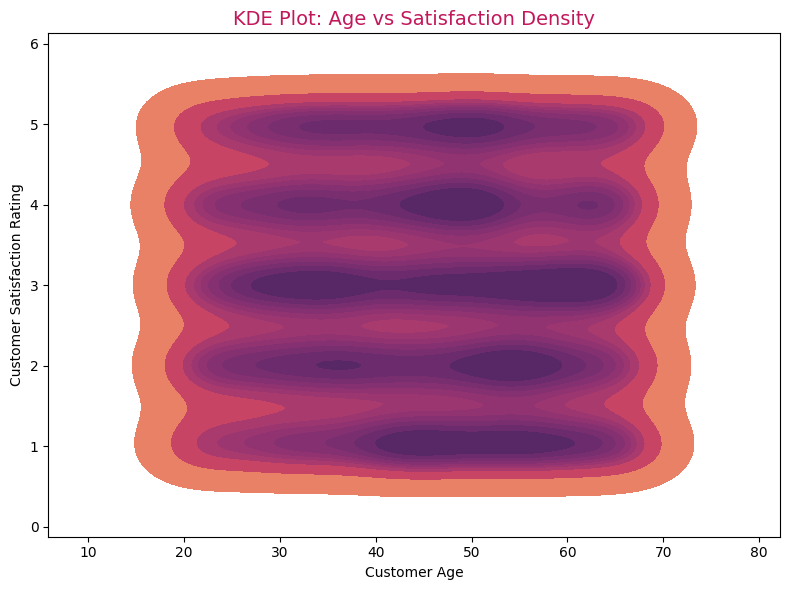

In [29]:
# KDE PLOT — Age vs Satisfaction Density
plt.figure(figsize=(8,6))
sns.kdeplot(x='Customer Age', y='Customer Satisfaction Rating', data=df_viz, cmap='flare', fill=True)
plt.title('KDE Plot: Age vs Satisfaction Density', fontsize=14, color='#C2185B')
plt.tight_layout()
plt.show()


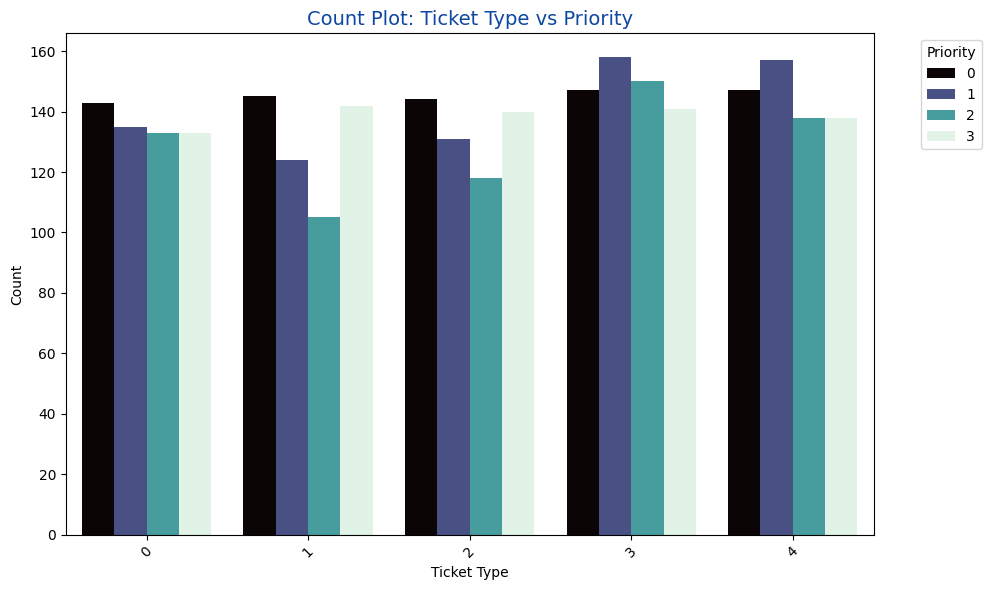

In [32]:
# COUNT PLOT — Ticket Type Distribution
if 'Ticket Type' in df_viz.columns:
    plt.figure(figsize=(10,6))
    sns.countplot(x='Ticket Type', data=df_viz, hue='Ticket Priority', palette='mako')
    plt.title('Count Plot: Ticket Type vs Priority', fontsize=14, color='#0D47A1')
    plt.xlabel('Ticket Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Priority', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

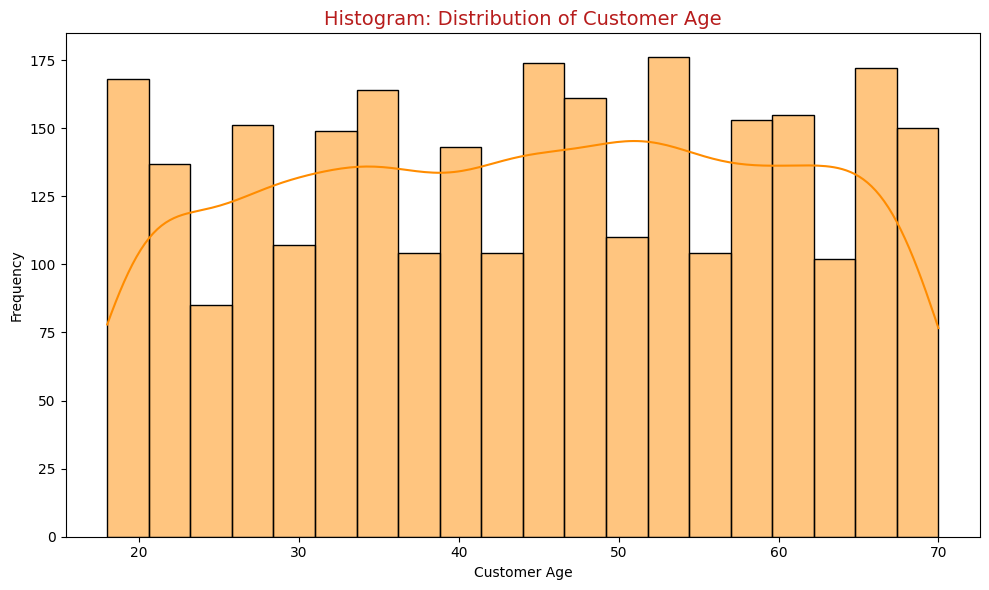

In [33]:
# HISTOGRAM — Customer Age
plt.figure(figsize=(10,6))
sns.histplot(df_viz['Customer Age'], bins=20, kde=True, color='#FF8C00')
plt.title('Histogram: Distribution of Customer Age', fontsize=14, color='#B71C1C')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
